In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

from tensorflow.keras import Sequential
from keras.layers import Dense

In [2]:
df=pd.read_csv("Toto Winning Numbers.csv" )
df.tail(10)

,Draw,Date,month,year,n_wd,wday,wn1,wn2,wn3,wn4,wn5,wn6,add_numb
1415,3757,18/04/2022,4,2022,1,monday,12,20,33,39,42,48,49
1416,3758,21/04/2022,4,2022,4,thursday,13,16,19,32,38,43,20
1417,3759,25/04/2022,4,2022,1,monday,6,16,26,32,39,47,23
1418,3760,28/04/2022,4,2022,4,thursday,5,6,11,16,22,37,44
1419,3761,02/05/2022,5,2022,1,monday,12,14,23,32,35,38,13
1420,3762,05/05/2022,5,2022,4,thursday,7,13,35,39,41,45,1
1421,3763,09/05/2022,5,2022,1,monday,5,12,15,21,30,39,6
1422,3764,12/05/2022,5,2022,4,thursday,15,20,36,38,41,46,10
1423,3765,16/05/2022,5,2022,1,monday,21,22,40,41,42,46,9
1424,3766,19/05/2022,5,2022,4,thursday,5,8,13,20,21,46,31


In [3]:
df.shape

(1425, 13)

In [4]:
# Scale down the values of winning number from 1-49 to 1-10 by grouping them
def group_number(col):
    output=[]
    for i in range(len(col)):
        if col[i] in range(0,6,1): 
            output.append("01")
        elif col[i] in range(6,11,1): 
            output.append("02")
        elif col[i] in range(11,16,1): 
            output.append("03")
        elif col[i] in range(16,21,1): 
            output.append("04")
        elif col[i] in range(21,26,1): 
            output.append("05")
        elif col[i] in range(26,31,1): 
            output.append("06")
        elif col[i] in range(31,36,1): 
            output.append("07")
        elif col[i] in range(36,41,1): 
            output.append("08")
        elif col[i] in range(41,46,1): 
            output.append("09")
        else: 
            output.append("10")
    return output

df['g_wn1'] = group_number(df.wn1) 
df['g_wn2'] = group_number(df.wn2)
df['g_wn3'] = group_number(df.wn3)
df['g_wn4'] = group_number(df.wn4)
df['g_wn5'] = group_number(df.wn5)
df['g_wn6'] = group_number(df.wn6)
df['g_wn7'] = group_number(df.add_numb)
df.head()

,Draw,Date,month,year,n_wd,wday,wn1,wn2,wn3,wn4,wn5,wn6,add_numb,g_wn1,g_wn2,g_wn3,g_wn4,g_wn5,g_wn6,g_wn7
0,2341,03/07/2008,7,2008,4,thursday,6,11,14,15,28,45,35,02,03,03,03,06,09,07
1,2342,07/07/2008,7,2008,1,monday,2,18,19,21,39,45,36,01,04,04,05,08,09,08
2,2343,10/07/2008,7,2008,4,thursday,22,32,41,42,43,44,31,05,07,09,09,09,09,07
3,2344,14/07/2008,7,2008,1,monday,5,12,17,18,38,40,22,01,03,04,04,08,08,05
4,2345,17/07/2008,7,2008,4,thursday,5,10,25,27,36,39,40,01,02,05,06,08,08,08


In [5]:
# vectors of 90 historical data points
n_data_points = 180

def numb_vector(col):
    v_n= []
    for i in range(df.shape[0] - n_data_points):
        vn =" ".join(col[i:i + n_data_points])
        v_n.append(vn)
    return v_n

vector=pd.DataFrame()
vector['v_n1']=numb_vector(df['g_wn1'])
vector['v_n2']=numb_vector(df['g_wn2'])
vector['v_n3']=numb_vector(df['g_wn3'])
vector['v_n4']=numb_vector(df['g_wn4'])
vector['v_n5']=numb_vector(df['g_wn5'])
vector['v_n6']=numb_vector(df['g_wn6'])
vector['v_n7']=numb_vector(df['g_wn7'])
vector.drop(vector.index[-1], inplace=True)
vector

,v_n1,v_n2,v_n3,v_n4,v_n5,v_n6,v_n7
0,02 01 05 01 01 01 01 01 02 01 03 01 02 01 01 0...,03 04 07 03 02 03 01 04 02 02 04 03 02 02 02 0...,03 04 09 04 05 05 02 05 03 03 04 03 06 04 04 0...,03 05 09 04 06 06 04 06 04 04 05 05 08 05 06 0...,06 08 09 08 08 08 05 07 06 09 05 07 08 06 09 0...,09 09 09 08 08 09 09 08 07 09 08 09 09 06 09 0...,07 08 07 05 08 01 03 05 03 05 07 02 08 06 05 0...
1,01 05 01 01 01 01 01 02 01 03 01 02 01 01 02 0...,04 07 03 02 03 01 04 02 02 04 03 02 02 02 02 0...,04 09 04 05 05 02 05 03 03 04 03 06 04 04 03 0...,05 09 04 06 06 04 06 04 04 05 05 08 05 06 03 0...,08 09 08 08 08 05 07 06 09 05 07 08 06 09 07 0...,09 09 08 08 09 09 08 07 09 08 09 09 06 09 08 0...,08 07 05 08 01 03 05 03 05 07 02 08 06 05 08 0...
2,05 01 01 01 01 01 02 01 03 01 02 01 01 02 01 0...,07 03 02 03 01 04 02 02 04 03 02 02 02 02 03 0...,09 04 05 05 02 05 03 03 04 03 06 04 04 03 04 0...,09 04 06 06 04 06 04 04 05 05 08 05 06 03 07 0...,09 08 08 08 05 07 06 09 05 07 08 06 09 07 09 0...,09 08 08 09 09 08 07 09 08 09 09 06 09 08 09 0...,07 05 08 01 03 05 03 05 07 02 08 06 05 08 02 0...
3,01 01 01 01 01 02 01 03 01 02 01 01 02 01 01 0...,03 02 03 01 04 02 02 04 03 02 02 02 02 03 03 0...,04 05 05 02 05 03 03 04 03 06 04 04 03 04 06 0...,04 06 06 04 06 04 04 05 05 08 05 06 03 07 07 0...,08 08 08 05 07 06 09 05 07 08 06 09 07 09 08 0...,08 08 09 09 08 07 09 08 09 09 06 09 08 09 08 0...,05 08 01 03 05 03 05 07 02 08 06 05 08 02 06 0...
4,01 01 01 01 02 01 03 01 02 01 01 02 01 01 02 0...,02 03 01 04 02 02 04 03 02 02 02 02 03 03 05 0...,05 05 02 05 03 03 04 03 06 04 04 03 04 06 07 0...,06 06 04 06 04 04 05 05 08 05 06 03 07 07 08 0...,08 08 05 07 06 09 05 07 08 06 09 07 09 08 08 0...,08 09 09 08 07 09 08 09 09 06 09 08 09 08 09 0...,08 01 03 05 03 05 07 02 08 06 05 08 02 06 09 0...
...,...,...,...,...,...,...,...
1239,02 01 01 02 01 01 03 01 02 03 01 01 03 01 01 0...,04 02 01 03 04 02 03 04 03 05 03 01 04 07 04 0...,04 06 03 04 05 03 04 06 04 06 03 02 04 08 06 0...,06 09 06 06 06 07 05 07 05 08 03 04 04 08 07 0...,08 09 07 06 08 09 05 09 08 08 06 08 06 09 09 0...,09 09 10 10 09 09 10 10 09 09 09 08 08 10 09 1...,08 06 08 09 05 05 10 02 05 09 08 01 06 06 10 0...
1240,01 01 02 01 01 03 01 02 03 01 01 03 01 01 02 0...,02 01 03 04 02 03 04 03 05 03 01 04 07 04 02 0...,06 03 04 05 03 04 06 04 06 03 02 04 08 06 03 0...,09 06 06 06 07 05 07 05 08 03 04 04 08 07 05 0...,09 07 06 08 09 05 09 08 08 06 08 06 09 09 06 0...,09 10 10 09 09 10 10 09 09 09 08 08 10 09 10 0...,06 08 09 05 05 10 02 05 09 08 01 06 06 10 03 0...
1241,01 02 01 01 03 01 02 03 01 01 03 01 01 02 02 0...,01 03 04 02 03 04 03 05 03 01 04 07 04 02 02 0...,03 04 05 03 04 06 04 06 03 02 04 08 06 03 03 0...,06 06 06 07 05 07 05 08 03 04 04 08 07 05 03 0...,07 06 08 09 05 09 08 08 06 08 06 09 09 06 08 0...,10 10 09 09 10 10 09 09 09 08 08 10 09 10 09 0...,08 09 05 05 10 02 05 09 08 01 06 06 10 03 01 0...
1242,02 01 01 03 01 02 03 01 01 03 01 01 02 02 01 0...,03 04 02 03 04 03 05 03 01 04 07 04 02 02 01 0...,04 05 03 04 06 04 06 03 02 04 08 06 03 03 02 0...,06 06 07 05 07 05 08 03 04 04 08 07 05 03 03 0...,06 08 09 05 09 08 08 06 08 06 09 09 06 08 05 0...,10 09 09 10 10 09 09 09 08 08 10 09 10 09 07 1...,09 05 05 10 02 05 09 08 01 06 06 10 03 01 09 0...


In [6]:
df.shape

(1425, 20)

In [7]:
df.year.unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022], dtype=int64)

### EDA

Text(0.5, 1.0, 'Winning numbers distribution from 7/2008 to 5/2022')

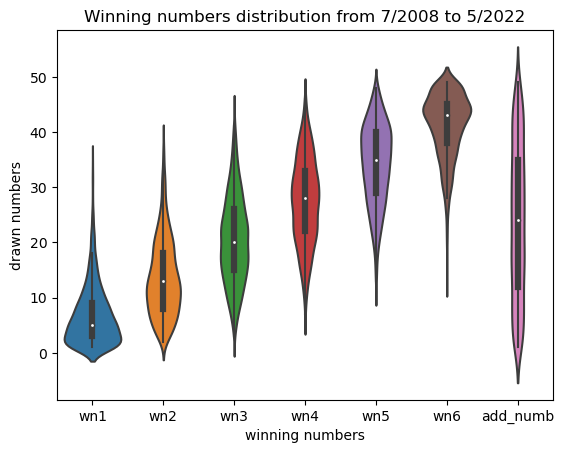

In [8]:
# general capture of how values of each winning number distributing from 2008-2022
sns.violinplot(data=df.iloc[:,6:13])
plt.xlabel("winning numbers")
plt.ylabel("drawn numbers")
plt.title("Winning numbers distribution from 7/2008 to 5/2022")

In [9]:
# count groups of each winning number
plot_n1= dict(df.g_wn1.value_counts(normalize=True))
plot_n2= dict(df.g_wn2.value_counts(normalize=True))
plot_n3= dict(df.g_wn3.value_counts(normalize=True))
plot_n4= dict(df.g_wn4.value_counts(normalize=True))
plot_n5= dict(df.g_wn5.value_counts(normalize=True))
plot_n6= dict(df.g_wn6.value_counts(normalize=True))
plot_n7= dict(df.g_wn7.value_counts(normalize=True))

plot_n1

{'01': 0.5059649122807017,
 '02': 0.2912280701754386,
 '03': 0.12631578947368421,
 '04': 0.04842105263157895,
 '05': 0.02175438596491228,
 '07': 0.0035087719298245615,
 '06': 0.002807017543859649}

In [10]:
# dataframe of all numerical groups each winning number was possibly fallen into 

groups = ["01","02","03","04","05","06","07","08","09","10"]
def distribution_number(plot_n):
    for k in groups:
        if k not in plot_n.keys():
            plot_n.update({k:0})
    plot_n= dict(sorted(plot_n.items()))    
    return plot_n

bar_plot=pd.DataFrame({"plot_n1":distribution_number(plot_n1).values(),
                     "plot_n2":distribution_number(plot_n2).values(),
                     "plot_n3":distribution_number(plot_n3).values(),
                     "plot_n4":distribution_number(plot_n4).values(),
                     "plot_n5":distribution_number(plot_n5).values(),
                     "plot_n6":distribution_number(plot_n6).values(),
                     "plot_n7":distribution_number(plot_n7).values()},
                     index=distribution_number(plot_n1).keys())

bar_plot



,plot_n1,plot_n2,plot_n3,plot_n4,plot_n5,plot_n6,plot_n7
01,0.505965,0.108070,0.011228,0.000000,0.000000,0.000000,0.105965
02,0.291228,0.268772,0.085614,0.009123,0.000000,0.000000,0.112281
03,0.126316,0.271579,0.190175,0.057544,0.007018,0.001404,0.091930
04,0.048421,0.185965,0.230877,0.130526,0.028070,0.002105,0.117193
05,0.021754,0.103860,0.223158,0.205614,0.097544,0.009123,0.103158
06,0.002807,0.037193,0.150877,0.231579,0.167018,0.046316,0.112982
07,0.003509,0.019649,0.074386,0.189474,0.224561,0.110175,0.108772
08,0.000000,0.004912,0.030175,0.135439,0.260351,0.209825,0.087719
09,0.000000,0.000000,0.003509,0.038596,0.175439,0.383158,0.108772
10,0.000000,0.000000,0.000000,0.002105,0.040000,0.237895,0.051228


Text(0.5, 1.0, 'Group distribution in each winning number')

<Figure size 2000x2000 with 0 Axes>

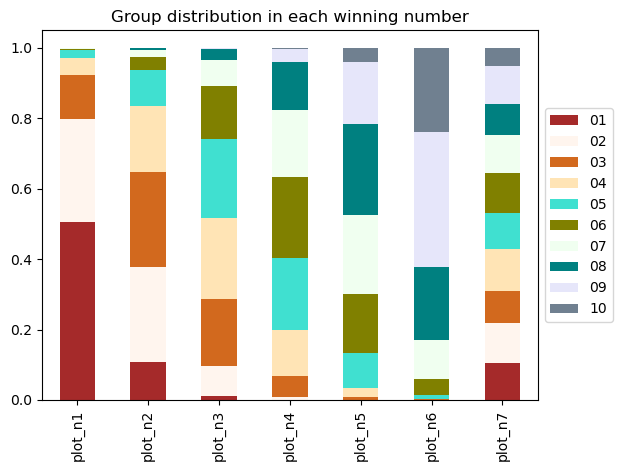

In [11]:
# graph showing how each winning number has different frequency of its numerical groups against the others
plt.figure(figsize=(20,20))
bar_plot.T.plot(kind="bar",stacked=True,color=['brown','seashell','chocolate','moccasin','turquoise','olive','honeydew','teal','lavender','slategrey'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Group distribution in each winning number")

### Modelling 

### NLP (TF-IDF Preprocessing) 

In [12]:

def tfidf_vector(v_n):
    tfidf = TfidfVectorizer()
    tfidf_n = np.round(tfidf.fit_transform(v_n),3)
    vocab = sorted(tfidf.vocabulary_.keys())
    X_n = pd.DataFrame(tfidf_n.toarray(),columns = vocab)
    return X_n

In [13]:
# Frequencies of each group in each winning number from gwn_1 to gwn_7
# Some groups have 0 frequency varying from gwn_1 to gwn_7

X_n1=tfidf_vector(vector.v_n1)
X_n2=tfidf_vector(vector.v_n2)
X_n3=tfidf_vector(vector.v_n3)
X_n4=tfidf_vector(vector.v_n4)
X_n5=tfidf_vector(vector.v_n5)
X_n6=tfidf_vector(vector.v_n6)
X_n7=tfidf_vector(vector.v_n7)


# reshape all X_n to have synchronized 10 columns 
def reshape_X(X_n):
    for i in groups:
        if i not in X_n.columns:
            X_n[i]=0
    X_n.columns = np.sort(X_n.columns)
    return X_n

X_n1 = reshape_X(X_n1)
X_n2 = reshape_X(X_n2)
X_n3 = reshape_X(X_n3)
X_n4 = reshape_X(X_n4)
X_n5 = reshape_X(X_n5)
X_n6 = reshape_X(X_n6)
X_n7 = reshape_X(X_n7)

X_n1

,01,02,03,04,05,06,07,08,09,10
0,0.886,0.420,0.170,0.089,0.045,0.0,0.000,0,0,0
1,0.886,0.420,0.170,0.089,0.045,0.0,0.000,0,0,0
2,0.886,0.420,0.170,0.089,0.045,0.0,0.000,0,0,0
3,0.888,0.417,0.169,0.089,0.036,0.0,0.000,0,0,0
4,0.883,0.428,0.169,0.089,0.036,0.0,0.000,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1239,0.867,0.464,0.175,0.044,0.018,0.0,0.014,0,0,0
1240,0.869,0.456,0.184,0.044,0.018,0.0,0.014,0,0,0
1241,0.863,0.467,0.185,0.044,0.018,0.0,0.014,0,0,0
1242,0.863,0.467,0.185,0.044,0.018,0.0,0.014,0,0,0


In [14]:

def packed_X(X_n):
    pack = []
    for i in range(X_n.shape[0]):
        pack.append(X_n.iloc[i,:].values)
    return pack

x1 = packed_X(X_n1)
x2 = packed_X(X_n2)
x3 = packed_X(X_n3)
x4 = packed_X(X_n4)
x5 = packed_X(X_n5)
x6 = packed_X(X_n6)
x7 = packed_X(X_n7)


X = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "x6": x6, "x7": x7})
X

,x1,x2,x3,x4,x5,x6,x7
0,"[0.886, 0.42, 0.17, 0.089, 0.045, 0.0, 0.0, 0....","[0.249, 0.621, 0.51, 0.447, 0.2860000000000000...","[0.026000000000000002, 0.192, 0.396, 0.55, 0.6...","[0.056, 0.151, 0.252, 0.505, 0.631, 0.454, 0.2...","[0.089, 0.06, 0.156, 0.419, 0.527, 0.659, 0.27...","[0.058, 0.0, 0.027, 0.10200000000000001, 0.26,...","[0.248, 0.364, 0.381, 0.364, 0.315, 0.315, 0.3..."
1,"[0.886, 0.42, 0.17, 0.089, 0.045, 0.0, 0.0, 0....","[0.249, 0.621, 0.51, 0.447, 0.2860000000000000...","[0.026000000000000002, 0.191, 0.382, 0.548, 0....","[0.056, 0.138, 0.251, 0.501, 0.639, 0.451, 0.2...","[0.089, 0.06, 0.156, 0.40700000000000003, 0.53...","[0.058, 0.0, 0.027, 0.10200000000000001, 0.26,...","[0.248, 0.364, 0.381, 0.364, 0.315, 0.315, 0.3..."
2,"[0.886, 0.42, 0.17, 0.089, 0.045, 0.0, 0.0, 0....","[0.249, 0.621, 0.51, 0.447, 0.2860000000000000...","[0.026000000000000002, 0.192, 0.384, 0.537, 0....","[0.056, 0.139, 0.252, 0.492, 0.643, 0.454, 0.2...","[0.09, 0.06, 0.156, 0.40900000000000003, 0.541...","[0.058, 0.0, 0.027, 0.10200000000000001, 0.26,...","[0.248, 0.364, 0.397, 0.364, 0.314, 0.314, 0.3..."
3,"[0.888, 0.417, 0.169, 0.089, 0.036000000000000...","[0.26, 0.62, 0.508, 0.446, 0.28500000000000003...","[0.026000000000000002, 0.20400000000000001, 0....","[0.056, 0.138, 0.264, 0.49, 0.641, 0.453, 0.22...","[0.089, 0.06, 0.156, 0.42, 0.54, 0.648, 0.276,...","[0.058, 0.0, 0.027, 0.112, 0.261, 0.401, 0.868...","[0.248, 0.364, 0.397, 0.364, 0.331, 0.314, 0.2..."
4,"[0.883, 0.428, 0.169, 0.089, 0.036000000000000...","[0.26, 0.62, 0.508, 0.446, 0.28500000000000003...","[0.026000000000000002, 0.20400000000000001, 0....","[0.056, 0.138, 0.251, 0.489, 0.64, 0.464, 0.22...","[0.089, 0.06, 0.156, 0.42, 0.54, 0.648, 0.276,...","[0.058, 0.0, 0.027, 0.112, 0.261, 0.401, 0.868...","[0.265, 0.364, 0.397, 0.364, 0.315, 0.315, 0.2..."
...,...,...,...,...,...,...,...
1239,"[0.867, 0.464, 0.17500000000000002, 0.044, 0.0...","[0.249, 0.634, 0.534, 0.435, 0.224, 0.08700000...","[0.014, 0.323, 0.499, 0.47200000000000003, 0.4...","[0.02, 0.22, 0.33, 0.439, 0.494, 0.56300000000...","[0.0, 0.076, 0.229, 0.343, 0.483, 0.635, 0.381...","[0.0, 0.0, 0.013000000000000001, 0.04300000000...","[0.333, 0.301, 0.127, 0.269, 0.222, 0.333, 0.2..."
1240,"[0.869, 0.456, 0.184, 0.044, 0.018000000000000...","[0.248, 0.633, 0.546, 0.422, 0.223, 0.08700000...","[0.014, 0.323, 0.498, 0.458, 0.498, 0.404, 0.1...","[0.02, 0.219, 0.329, 0.439, 0.48, 0.5760000000...","[0.0, 0.076, 0.229, 0.343, 0.496, 0.623, 0.382...","[0.0, 0.0, 0.013000000000000001, 0.04300000000...","[0.334, 0.302, 0.14300000000000002, 0.27, 0.22..."
1241,"[0.863, 0.467, 0.185, 0.044, 0.018000000000000...","[0.248, 0.621, 0.559, 0.422, 0.224, 0.08700000...","[0.014, 0.324, 0.5, 0.46, 0.5, 0.392, 0.149, 0...","[0.02, 0.219, 0.329, 0.438, 0.4790000000000000...","[0.0, 0.076, 0.229, 0.343, 0.496, 0.623, 0.382...","[0.0, 0.0, 0.013000000000000001, 0.04300000000...","[0.35000000000000003, 0.302, 0.143000000000000..."
1242,"[0.863, 0.467, 0.185, 0.044, 0.018000000000000...","[0.23500000000000001, 0.619, 0.569000000000000...","[0.014, 0.324, 0.5, 0.46, 0.5, 0.392, 0.149, 0...","[0.02, 0.219, 0.329, 0.452, 0.466, 0.576000000...","[0.0, 0.076, 0.229, 0.357, 0.484, 0.624, 0.382...","[0.0, 0.0, 0.013000000000000001, 0.04300000000...","[0.35000000000000003, 0.318, 0.143000000000000..."


In [15]:
def fit_model(model,x,y):
    fit1 = model.fit(list(x.iloc[:,0]),list(y.iloc[:,0]))
    fit2 = model.fit(list(x.iloc[:,1]),list(y.iloc[:,1]))
    fit3 = model.fit(list(x.iloc[:,2]),list(y.iloc[:,2]))
    fit4 = model.fit(list(x.iloc[:,3]),list(y.iloc[:,3]))
    fit5 = model.fit(list(x.iloc[:,4]),list(y.iloc[:,4]))
    fit6 = model.fit(list(x.iloc[:,5]),list(y.iloc[:,5]))
    fit7 = model.fit(list(x.iloc[:,6]),list(y.iloc[:,6]))
    return [fit1,fit2,fit3,fit4,fit5,fit6,fit7]
    
def model_acc(model,x,y):
    fit_m = fit_model(model,x,y)
    score1 = fit_m[0].score(list(x.iloc[:,0]),list(y.iloc[:,0]))
    score2 = fit_m[1].score(list(x.iloc[:,1]),list(y.iloc[:,1]))
    score3 = fit_m[2].score(list(x.iloc[:,2]),list(y.iloc[:,2]))
    score4 = fit_m[3].score(list(x.iloc[:,3]),list(y.iloc[:,3]))
    score5 = fit_m[4].score(list(x.iloc[:,4]),list(y.iloc[:,4]))
    score6 = fit_m[5].score(list(x.iloc[:,5]),list(y.iloc[:,5]))
    score7 = fit_m[6].score(list(x.iloc[:,6]),list(y.iloc[:,6]))
    
    return [score1, score2, score3, score4, score5, score6, score7]

def model_prediction(model,x,y):
    fit_m = fit_model(model,x,y)
    pred_y1 = fit_m[0].predict(list(x.iloc[:,0]))
    pred_y2 = fit_m[1].predict(list(x.iloc[:,1]))
    pred_y3 = fit_m[2].predict(list(x.iloc[:,2]))
    pred_y4 = fit_m[3].predict(list(x.iloc[:,3]))
    pred_y5 = fit_m[4].predict(list(x.iloc[:,4]))
    pred_y6 = fit_m[5].predict(list(x.iloc[:,5]))
    pred_y7 = fit_m[6].predict(list(x.iloc[:,6]))
    
    pred_y = pd.DataFrame({"pred_wn1": pred_y1,"pred_wn2": pred_y2,"pred_w3": pred_y3,"pred_wn4": pred_y4,"pred_wn5": pred_y5,"pred_wn6": pred_y6,"pred_wn7": pred_y7})
    return pred_y

def count_crosscheck_winner(df_pred, df_true):
    win_count = []
    for k in range(len(df_true)):
      win_count.append(len([i for i, j in zip(df_pred.iloc[k, :-1].values, df_true.iloc[k, :-1].values) if i == j]))
    return win_count

def count_crosscheck_winner7(df_pred, df_true):
    win_count = []
    for k in range(len(df_true)):
        if df_pred.iloc[k,6]== df_true.iloc[k,6]:
            win_count.append(1)
        else: win_count.append(0)
    return win_count


def all_model_acc(models=[], x=[], y=[]):
    all_model_scores =[]
    x = x
    y = y
    for i in models:
        all_model_scores.append(model_acc(i,x,y))
    return all_model_scores
        

In [16]:
# Split X into train, test datasets
from sklearn.model_selection import KFold

# skip the first 90 drawing days for collecting historical data, then start to predict after that 
predict_start_point = n_data_points + 1 

y = df.loc[predict_start_point:,["g_wn1","g_wn2","g_wn3","g_wn4","g_wn5","g_wn6","g_wn7"]]

# split Xs, ys into train, test datasets 
# Shuffle Xs but not ys

test_size = 0.20

cv = KFold(n_splits=5,shuffle=True, random_state = 1)

#y_train, y_test = train_test_split(y, test_size = test_size, shuffle = False)

#X_train, X_test  = train_test_split(X, test_size = test_size, shuffle = cv) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, shuffle= cv)

In [17]:
def model_report(model,model_name):
    print("\nModel prediction {} accuracy train_scores:\n".format(model_name),model_acc(model,X_train,y_train))
    print("\nModel prediction {} accuracy test_scores:\n".format(model_name),model_acc(model,X_test,y_test))
    print("\n","*"*50)

    print("\nValues predicted by {} model in test set:\n".format(model_name))
    print("predicted possible groups in wn1:     ",model_prediction(model,X_test,y_test).iloc[:,0].unique() )
    print("predicted possible groups in wn2:     ",model_prediction(model,X_test,y_test).iloc[:,1].unique() )
    print("predicted possible groups in wn3:     ",model_prediction(model,X_test,y_test).iloc[:,2].unique() )
    print("predicted possible groups in wn4:     ",model_prediction(model,X_test,y_test).iloc[:,3].unique() )
    print("predicted possible groups in wn5:     ",model_prediction(model,X_test,y_test).iloc[:,4].unique() )
    print("predicted possible groups in wn6:     ",model_prediction(model,X_test,y_test).iloc[:,5].unique() )
    print("predicted possible groups in wn7:     ",model_prediction(model,X_test,y_test).iloc[:,6].unique() )

    print("\n","*"*50)
    
    pred_y = model_prediction(model,X_test,y_test)
    y_test.reset_index(drop=True, inplace=True)
    
    pred_y['count_win_number'] = count_crosscheck_winner(pred_y, y_test)
    pred_y['count_win_number7'] = count_crosscheck_winner7(pred_y, y_test)
    print("Prizes are given to cases with at least 3 correct predicted numbers:\n\nTotal number of true predicted cases by {}\n\n".format(model_name), pred_y.groupby('count_win_number').size())
    print("\nNumber of cases with correct prediction of the additional number (wn7): {}".format(pred_y['count_win_number7'].sum()))
    print("Number of cases with at least 3 correct numbers plus the additional number: {}".format(pred_y[(pred_y.count_win_number >=3) & (pred_y.count_win_number7 >=1)].shape[0])) 
   
    print("\n","/-"*60)
    
model_report(DecisionTreeClassifier(random_state=1),"Decision_Tree_Classification")    
model_report(svm.SVC(),"Support_Vector_Classification")
model_report(MultinomialNB(),"Multinomial_Naive_Bayes")
#model_report(KNeighborsClassifier(),"KNN")
model_report(RandomForestClassifier(),"Random_Forest_Classification")


Model prediction Decision_Tree_Classification accuracy train_scores:
 [0.003015075376884422, 0.0964824120603015, 0.23316582914572864, 0.12864321608040202, 0.02814070351758794, 0.0010050251256281408, 0.9195979899497487]

Model prediction Decision_Tree_Classification accuracy test_scores:
 [0.15261044176706828, 0.0642570281124498, 0.06827309236947791, 0.14056224899598393, 0.060240963855421686, 0.0, 0.963855421686747]

 **************************************************

Values predicted by Decision_Tree_Classification model in test set:

predicted possible groups in wn1:      ['03']
predicted possible groups in wn2:      ['06' '01' '08' '07' '03' '04']
predicted possible groups in wn3:      ['10' '05' '02' '09']
predicted possible groups in wn4:      ['05' '08' '10' '09' '02']
predicted possible groups in wn5:      ['05' '03' '08']
predicted possible groups in wn6:      ['03']
predicted possible groups in wn7:      ['03' '08' '09' '05' '01' '06' '10' '04' '02' '07']

 ******************

                        pred_g_wn1  pred_g_wn2  pred_g_wn3  pred_g_wn4  \
DecisionTreeClassifier    0.003015    0.086432    0.192965    0.130653   
RandomForestClassifier    0.001005    0.009045    0.096482    0.044221   
SVM                       0.003015    0.033166    0.155779    0.218090   
MultinomialNB             0.000000    0.019095    0.154774    0.217085   

                        pred_g_wn5  pred_g_wn6  pred_g_wn7  
DecisionTreeClassifier    0.028141    0.002010    0.919598  
RandomForestClassifier    0.073367    0.000000    0.919598  
SVM                       0.171859    0.043216    0.179899  
MultinomialNB             0.161809    0.043216    0.129648  


C:\Users\nhivo\AppData\Local\Temp\ipykernel_20004\49616015.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=plot_acc.columns,rotation=45)


Text(0.5, 1.0, 'Train_scores (TF-IDF Preprocessing)\nObserved days: 180\nCross validation: Shuffle X, not shuffle y')

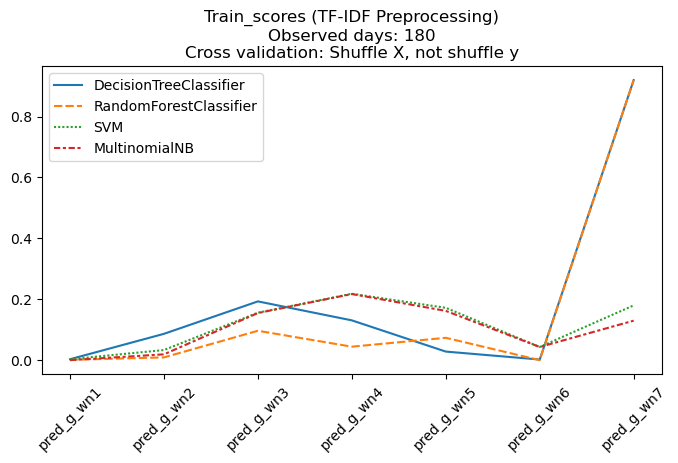

In [18]:
acc=all_model_acc(models=[DecisionTreeClassifier(),RandomForestClassifier(),svm.SVC(),MultinomialNB()],x = X_train,y = y_train)
plot_acc = pd.DataFrame(data = acc, columns = ['pred_' + i for i in y_test.columns], 
                                               index =['DecisionTreeClassifier','RandomForestClassifier','SVM','MultinomialNB'])
print(plot_acc) 

plt.figure(figsize=(8,4))
sns.lineplot(data=plot_acc.T)
ax=plt.gca()
ax.set_xticklabels(labels=plot_acc.columns,rotation=45)
plt.title("Train_scores (TF-IDF Preprocessing)\nObserved days: {}\nCross validation: Shuffle X, not shuffle y".format(n_data_points))


                        pred_g_wn1  pred_g_wn2  pred_g_wn3  pred_g_wn4  \
DecisionTreeClassifier    0.000000    0.261044    0.148594    0.176707   
RandomForestClassifier    0.028112    0.040161    0.176707    0.140562   
SVM                       0.032129    0.116466    0.136546    0.048193   
MultinomialNB             0.032129    0.116466    0.216867    0.148594   

                        pred_g_wn5  pred_g_wn6  pred_g_wn7  
DecisionTreeClassifier    0.060241    0.000000    0.963855  
RandomForestClassifier    0.068273    0.048193    0.963855  
SVM                       0.040161    0.008032    0.261044  
MultinomialNB             0.088353    0.008032    0.152610  


C:\Users\nhivo\AppData\Local\Temp\ipykernel_20004\1482238456.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=plot_acc.columns,rotation=45)


Text(0.5, 1.0, 'Test_scores (TF-IDF Preprocessing)\nObserved days: 180\nCross validation: Shuffle X, not shuffle y')

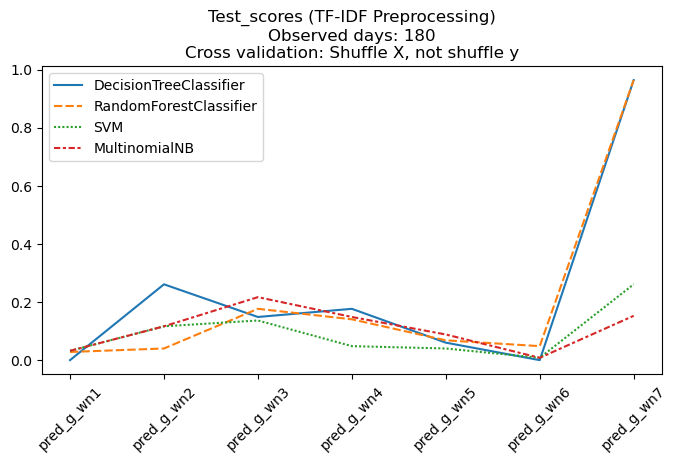

In [19]:
acc=all_model_acc(models=[DecisionTreeClassifier(),RandomForestClassifier(),svm.SVC(),MultinomialNB()],x = X_test,y = y_test)
plot_acc = pd.DataFrame(data = acc, columns = ['pred_' + i for i in y_test.columns], 
                                               index =['DecisionTreeClassifier','RandomForestClassifier','SVM','MultinomialNB'])
print(plot_acc) 

plt.figure(figsize=(8,4))
sns.lineplot(data=plot_acc.T)
ax=plt.gca()
ax.set_xticklabels(labels=plot_acc.columns,rotation=45)
plt.title("Test_scores (TF-IDF Preprocessing)\nObserved days: {}\nCross validation: Shuffle X, not shuffle y".format(n_data_points))


### NLP (CountVectorizer Preprocessing)

In [20]:
def count_vectorizer(v_n):
    vectorizer=CountVectorizer()
    vect_n=vectorizer.fit_transform(v_n)
    vocab=sorted(vectorizer.vocabulary_.keys())
    X_n=pd.DataFrame(vect_n.todense(),columns=vocab)
    return X_n

In [21]:
# Frequencies of each group in each winning number from gwn_1 to gwn_7
# Some groups have 0 frequency varying from gwn_1 to gwn_7

X_n1=count_vectorizer(vector['v_n1'])
X_n2=count_vectorizer(vector['v_n2'])
X_n3=count_vectorizer(vector['v_n3'])
X_n4=count_vectorizer(vector['v_n4'])
X_n5=count_vectorizer(vector['v_n5'])
X_n6=count_vectorizer(vector['v_n6'])
X_n7=count_vectorizer(vector['v_n7'])


# reshape all X_n to have synchronized 10 columns 
def reshape_X(X_n):
    for i in groups:
        if i not in X_n.columns:
            X_n[i]=0
    X_n.columns = np.sort(X_n.columns)
    return X_n

X_n1 = reshape_X(X_n1)
X_n2 = reshape_X(X_n2)
X_n3 = reshape_X(X_n3)
X_n4 = reshape_X(X_n4)
X_n5 = reshape_X(X_n5)
X_n6 = reshape_X(X_n6)
X_n7 = reshape_X(X_n7)

X_n1.head()

,01,02,03,04,05,06,07,08,09,10
0,99,47,19,10,5,0,0,0,0,0
1,99,47,19,10,5,0,0,0,0,0
2,99,47,19,10,5,0,0,0,0,0
3,100,47,19,10,4,0,0,0,0,0
4,99,48,19,10,4,0,0,0,0,0


In [22]:
def packed_X(X_n):
    pack = []
    for i in range(X_n.shape[0]):
        pack.append(X_n.iloc[i,:].values)
    return pack

x1 = packed_X(X_n1)
x2 = packed_X(X_n2)
x3 = packed_X(X_n3)
x4 = packed_X(X_n4)
x5 = packed_X(X_n5)
x6 = packed_X(X_n6)
x7 = packed_X(X_n7)


X = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "x6": x6, "x7": x7})
X.head()

,x1,x2,x3,x4,x5,x6,x7
0,"[99, 47, 19, 10, 5, 0, 0, 0, 0, 0]","[20, 50, 41, 36, 23, 8, 2, 0, 0, 0]","[2, 15, 31, 43, 48, 22, 17, 1, 1, 0]","[3, 12, 20, 40, 50, 36, 18, 1, 0, 0]","[5, 5, 13, 35, 44, 55, 23, 0, 0, 0]","[2, 0, 2, 11, 28, 43, 94, 0, 0, 0]","[15, 22, 23, 22, 19, 19, 19, 21, 20, 0]"
1,"[99, 47, 19, 10, 5, 0, 0, 0, 0, 0]","[20, 50, 41, 36, 23, 8, 2, 0, 0, 0]","[2, 15, 30, 43, 49, 22, 17, 1, 1, 0]","[3, 11, 20, 40, 51, 36, 18, 1, 0, 0]","[5, 5, 13, 34, 45, 55, 23, 0, 0, 0]","[2, 0, 2, 11, 28, 43, 94, 0, 0, 0]","[15, 22, 23, 22, 19, 19, 19, 21, 20, 0]"
2,"[99, 47, 19, 10, 5, 0, 0, 0, 0, 0]","[20, 50, 41, 36, 23, 8, 2, 0, 0, 0]","[2, 15, 30, 42, 49, 23, 17, 1, 1, 0]","[3, 11, 20, 39, 51, 36, 18, 2, 0, 0]","[5, 5, 13, 34, 45, 54, 24, 0, 0, 0]","[2, 0, 2, 11, 28, 43, 94, 0, 0, 0]","[15, 22, 24, 22, 19, 19, 19, 20, 20, 0]"
3,"[100, 47, 19, 10, 4, 0, 0, 0, 0, 0]","[21, 50, 41, 36, 23, 8, 1, 0, 0, 0]","[2, 16, 30, 42, 49, 23, 17, 1, 0, 0]","[3, 11, 21, 39, 51, 36, 18, 1, 0, 0]","[5, 5, 13, 35, 45, 54, 23, 0, 0, 0]","[2, 0, 2, 12, 28, 43, 93, 0, 0, 0]","[15, 22, 24, 22, 20, 19, 18, 20, 20, 0]"
4,"[99, 48, 19, 10, 4, 0, 0, 0, 0, 0]","[21, 50, 41, 36, 23, 8, 1, 0, 0, 0]","[2, 16, 30, 41, 50, 23, 17, 1, 0, 0]","[3, 11, 20, 39, 51, 37, 18, 1, 0, 0]","[5, 5, 13, 35, 45, 54, 23, 0, 0, 0]","[2, 0, 2, 12, 28, 43, 93, 0, 0, 0]","[16, 22, 24, 22, 19, 19, 18, 20, 20, 0]"


In [23]:

# skip the first 90 drawing days for collecting historical data, then start to predict after that 
predict_start_point = n_data_points + 1 

y = df.loc[predict_start_point:,["g_wn1","g_wn2","g_wn3","g_wn4","g_wn5","g_wn6","g_wn7"]]

# split ys into train, test datasets 
test_size = 0.2

cv = KFold(n_splits=5,shuffle=True, random_state = 1)

#y_train, y_test = train_test_split(y, test_size = test_size, shuffle = False)

#X_train, X_test  = train_test_split(X, test_size = test_size, shuffle = cv)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, shuffle = cv)

In [24]:
model_report(DecisionTreeClassifier(),"Decision_Tree_Classification")    
model_report(svm.SVC(),"Support_Vector_Classification")
model_report(MultinomialNB(),"Multinomial_Naive_Bayes")
#model_report(KNeighborsClassifier(),"KNN")
model_report(RandomForestClassifier(),"Random_Forest_Classification")


Model prediction Decision_Tree_Classification accuracy train_scores:
 [0.2723618090452261, 0.053266331658291456, 0.004020100502512563, 0.07236180904522613, 0.11055276381909548, 0.1507537688442211, 0.9175879396984925]

Model prediction Decision_Tree_Classification accuracy test_scores:
 [0.0, 0.10441767068273092, 0.12048192771084337, 0.19678714859437751, 0.13253012048192772, 0.008032128514056224, 0.9759036144578314]

 **************************************************

Values predicted by Decision_Tree_Classification model in test set:

predicted possible groups in wn1:      ['10' '09']
predicted possible groups in wn2:      ['06' '09']
predicted possible groups in wn3:      ['06']
predicted possible groups in wn4:      ['10' '07']
predicted possible groups in wn5:      ['10' '01' '06']
predicted possible groups in wn6:      ['01' '05' '09']
predicted possible groups in wn7:      ['08' '05' '02' '01' '06' '07' '10' '09' '04' '03']

 **************************************************
Pr

                        pred_g_wn1  pred_g_wn2  pred_g_wn3  pred_g_wn4  \
DecisionTreeClassifier    0.235176    0.053266    0.004020    0.072362   
RandomForestClassifier    0.046231    0.039196    0.013065    0.000000   
SVM                       0.043216    0.176884    0.224121    0.130653   
MultinomialNB             0.298492    0.176884    0.076382    0.003015   

                        pred_g_wn5  pred_g_wn6  pred_g_wn7  
DecisionTreeClassifier    0.110553    0.150754    0.917588  
RandomForestClassifier    0.012060    0.000000    0.917588  
SVM                       0.029146    0.003015    0.186935  
MultinomialNB             0.000000    0.272362    0.111558  


C:\Users\nhivo\AppData\Local\Temp\ipykernel_20004\1533397754.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=plot_acc.columns,rotation=45)


Text(0.5, 1.0, 'Train_scores (CountVectorizer Preprocessing)\nObserved days: 180\nCross validation: Shuffle X, not shuffle y')

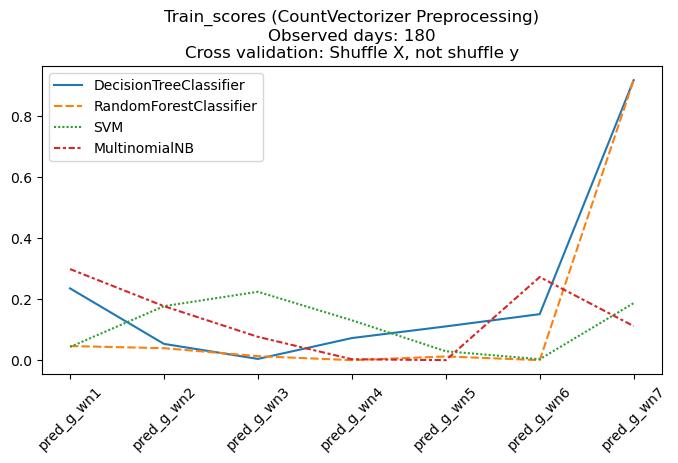

In [25]:
acc=all_model_acc(models=[DecisionTreeClassifier(),RandomForestClassifier(),svm.SVC(),MultinomialNB()],x = X_train,y = y_train)
plot_acc = pd.DataFrame(data = acc, columns = ['pred_' + i for i in y_test.columns], 
                                               index =['DecisionTreeClassifier','RandomForestClassifier','SVM','MultinomialNB'])
print(plot_acc) 

plt.figure(figsize=(8,4))
sns.lineplot(data=plot_acc.T)
ax=plt.gca()
ax.set_xticklabels(labels=plot_acc.columns,rotation=45)
plt.title("Train_scores (CountVectorizer Preprocessing)\nObserved days: {}\nCross validation: Shuffle X, not shuffle y".format(n_data_points))

                        pred_g_wn1  pred_g_wn2  pred_g_wn3  pred_g_wn4  \
DecisionTreeClassifier    0.032129    0.212851    0.120482    0.196787   
RandomForestClassifier    0.008032    0.016064    0.212851    0.144578   
SVM                       0.000000    0.028112    0.120482    0.196787   
MultinomialNB             0.108434    0.000000    0.128514    0.116466   

                        pred_g_wn5  pred_g_wn6  pred_g_wn7  
DecisionTreeClassifier    0.132530    0.008032    0.975904  
RandomForestClassifier    0.088353    0.004016    0.975904  
SVM                       0.172691    0.048193    0.228916  
MultinomialNB             0.088353    0.120482    0.136546  


C:\Users\nhivo\AppData\Local\Temp\ipykernel_20004\2476656971.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=plot_acc.columns,rotation=45)


Text(0.5, 1.0, 'Test_scores (CountVectorizer Preprocessing)\nObserved days: 180\nCross validation: Shuffle X, not shuffle y')

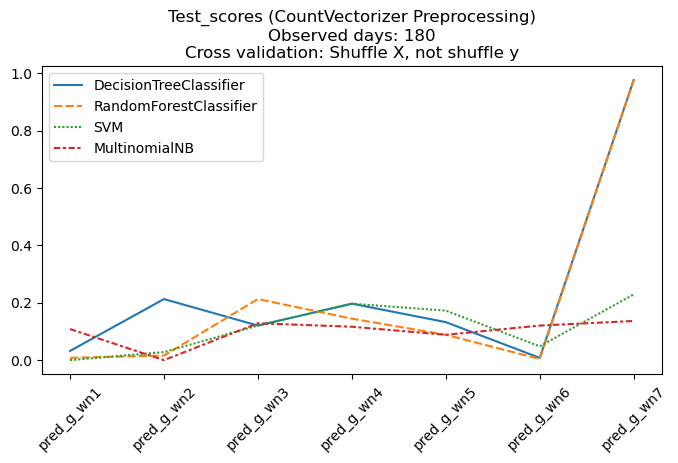

In [26]:
acc=all_model_acc(models=[DecisionTreeClassifier(),RandomForestClassifier(),svm.SVC(),MultinomialNB()],x = X_test,y = y_test)
plot_acc = pd.DataFrame(data = acc, columns = ['pred_' + i for i in y_test.columns], 
                                               index =['DecisionTreeClassifier','RandomForestClassifier','SVM','MultinomialNB'])
print(plot_acc) 

plt.figure(figsize=(8,4))
sns.lineplot(data=plot_acc.T)
ax=plt.gca()
ax.set_xticklabels(labels=plot_acc.columns,rotation=45)
plt.title("Test_scores (CountVectorizer Preprocessing)\nObserved days: {}\nCross validation: Shuffle X, not shuffle y".format(n_data_points))

### Neural Network Model

In [27]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.layers as L
import tensorflow as tf 
import tensorflow.keras.models as M
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

In [28]:
df2=df[['g_wn1', 'g_wn2', 'g_wn3', 'g_wn4', 'g_wn5', 'g_wn6', 'g_wn7']]
df2.shape

(1425, 7)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(df2.values)
transformed_dataset = scaler.transform(df2.values)
transformed_df = pd.DataFrame(data=transformed_dataset, index=df2.index)

In [30]:
n_data_point = 90
number_of_rows= df2.values.shape[0]

In [31]:
train = np.empty([number_of_rows-n_data_point, n_data_point, 7], dtype=float)
label = np.empty([number_of_rows-n_data_point, 7], dtype=float)

for i in range(0, number_of_rows - n_data_point):
    train[i]=transformed_df.iloc[i:i+n_data_point, 0: 7]
    label[i]=df2.iloc[i+n_data_point: i+n_data_point+1, 0: 7]

In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(train,label,test_size=0.15)

In [43]:
model = Sequential()
model.add(LSTM(32,      
           input_shape=(n_data_point, 7),
           return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(32,           
            return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
hist= model.fit(X_train, Y_train,batch_size=64, validation_split=0.2,verbose=0, epochs=100)

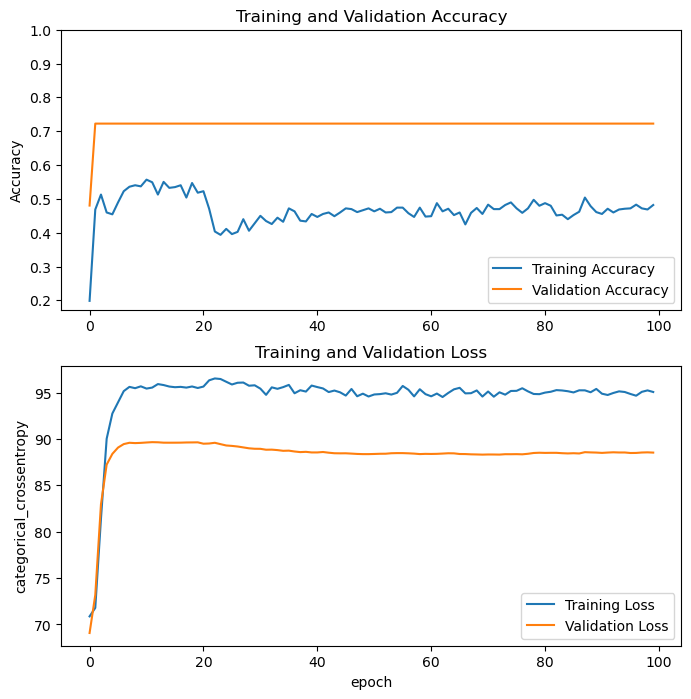

In [44]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('categorical_crossentropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
def count_crosscheck_winner7(df_pred, df_true):
  win_count = []
  for k in range(len(df_true)):
    win_count.append(len([i for i, j in zip(df_pred.iloc[k, -1:].values, df_true.iloc[k, -1:].values) if i == j]))
  return win_count

In [45]:
r = model.predict(X_test)
data = scaler.inverse_transform(r).astype(int)
dfoutput = pd.DataFrame(data, columns=df2.columns)
dfoutput

7/7 [==============================] - 1s 13ms/step


,g_wn1,g_wn2,g_wn3,g_wn4,g_wn5,g_wn6,g_wn7
0,2,3,4,5,7,9,5
1,2,3,4,5,7,9,5
2,2,3,4,5,7,9,5
3,2,3,4,5,7,9,5
4,2,3,4,5,7,9,5
...,...,...,...,...,...,...,...
196,2,3,4,5,7,9,5
197,2,3,4,5,7,9,5
198,2,3,4,5,7,9,5
199,2,3,4,5,7,9,5


In [46]:
result_y_test = pd.DataFrame(Y_test,columns=df2.columns)
dfoutput['count_win_number'] = count_crosscheck_winner(dfoutput, result_y_test)
dfoutput.groupby('count_win_number').size()

count_win_number
0    47
1    63
2    46
3    36
4     7
5     2
dtype: int64

In [47]:
dfoutput['count_win_number7'] = count_crosscheck_winner7(dfoutput, result_y_test)
dfoutput.groupby('count_win_number7').size()

count_win_number7
0    193
1      8
dtype: int64

In [48]:
dfoutput[(dfoutput.count_win_number >=3)].info() # 45/201 test cases will have prize

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 2 to 197
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   g_wn1              45 non-null     int32
 1   g_wn2              45 non-null     int32
 2   g_wn3              45 non-null     int32
 3   g_wn4              45 non-null     int32
 4   g_wn5              45 non-null     int32
 5   g_wn6              45 non-null     int32
 6   g_wn7              45 non-null     int32
 7   count_win_number   45 non-null     int64
 8   count_win_number7  45 non-null     int64
dtypes: int32(7), int64(2)
memory usage: 2.3 KB


In [49]:
dfoutput[(dfoutput.count_win_number >=3) & (dfoutput.count_win_number7 >=1)] # 2 cases are predicted right group

,g_wn1,g_wn2,g_wn3,g_wn4,g_wn5,g_wn6,g_wn7,count_win_number,count_win_number7
24,2,3,4,5,7,9,5,3,1
86,2,3,4,5,7,9,5,4,1


In [50]:
scr, acc = model.evaluate(X_train, Y_train)
print("Accuracy train: " + str(acc))

36/36 [==============================] - 1s 17ms/step - loss: 89.4860 - acc: 0.6984
Accuracy train: 0.6984127163887024


In [51]:
scr, acc = model.evaluate(X_test, Y_test)
print("Accuracy test: " + str(acc))

7/7 [==============================] - 0s 13ms/step - loss: 91.6146 - acc: 0.6517
Accuracy test: 0.6517412662506104
